In [1]:
import cv2
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

/home/wald/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def load_results_to_df(path: str) -> pd.DataFrame:
    """Load results.json and return a DataFrame of false positive scores."""
    # Load JSON
    with open(path, "r") as f:
        data = json.load(f)

    # Prepare rows
    rows = []
    for entry in data:
        filename = entry["filename"]
        fp = entry["false_positives"]
        for box_index, score in enumerate(fp["scores"]):
            rows.append({
                "filename": filename,
                "box_index": box_index,
                "score": score
            })

    # Make DataFrame
    return pd.DataFrame(rows)

In [3]:
df_train7 = load_results_to_df("/home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/train7_test_prediction_468/results.json")
df_train10 = load_results_to_df("/home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/train10_test_prediction_435/results.json")
df_train7

,filename,box_index,score
0,BRAIIM_0157.jpg,0,0.742782
1,BRAIIM_0157.jpg,1,0.689532
2,BRAIIM_0157.jpg,2,0.659174
3,BRAIIM_0157.jpg,3,0.621905
4,BRAIIM_0157.jpg,4,0.470081
...,...,...,...
834,TRIAVA_0628.jpg,1,0.779861
835,TRIAVA_0628.jpg,2,0.755290
836,TRIAVA_0628.jpg,3,0.704041
837,TRIAVA_0628.jpg,4,0.682667


In [4]:
import matplotlib.pyplot as plt

def plot_prefix_histograms(df, prefixes):
    """Plot histograms of FP scores for multiple prefixes in a 2x2 grid."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # make it easier to loop over
    
    for i, prefix in enumerate(prefixes):
        ax = axes[i]
        # Filter and sort data
        df_sorted = (
            df[df["filename"].str.startswith(prefix)]
            .reset_index(drop=True)
            .sort_values(by="score", ascending=False)
        )
        # Plot histogram
        ax.hist(df_sorted["score"], bins=20, color="skyblue", edgecolor="black")
        ax.set_xlabel("FP Confidence Score")
        ax.set_ylabel("Number of False Positives")
        ax.set_title(f"{prefix} - Distribution of FP Scores")
        ax.grid(axis="y", alpha=0.7)

    # Hide unused subplots if prefixes < 4
    for j in range(len(prefixes), 4):
        fig.delaxes(axes[j])

    fig.suptitle("False Positive Score Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


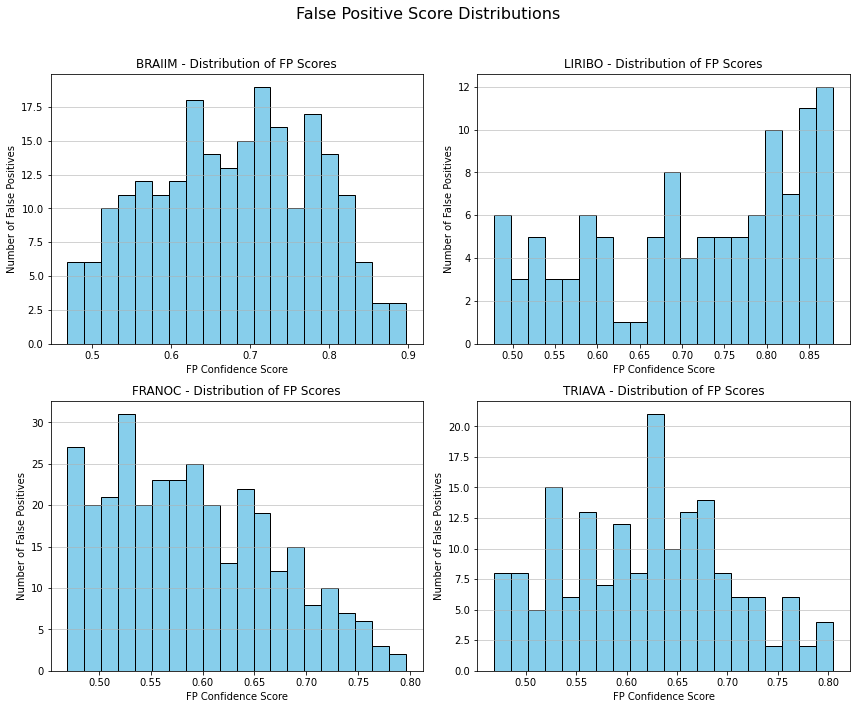

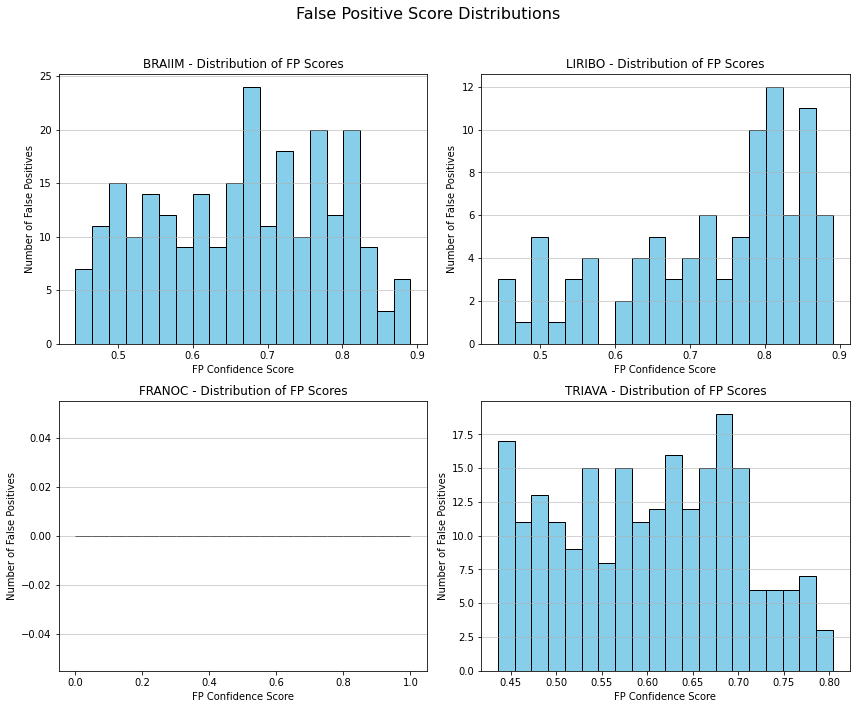

In [5]:
prefixes = ["BRAIIM", "LIRIBO", "FRANOC", "TRIAVA"]
plot_prefix_histograms(df_train7, prefixes)
plot_prefix_histograms(df_train10, prefixes)



In [6]:
def split_and_sort_by_prefix(df, prefixes):
    """
    Split DataFrame by filename prefixes and sort each subset by score.
    
    Returns a dict: {prefix: DataFrame}
    """
    result = {}
    for prefix in prefixes:
        df_sub = (
            df[df["filename"].str.startswith(prefix)]
            .sort_values(by="score", ascending=False)
            .reset_index(drop=True)
        )
        result[prefix] = df_sub
    return result

def count_common_entries(df1, df2):
    # Use merge to find overlaps
    common = pd.merge(
        df1, df2,
        on=["filename", "box_index"],
        how="inner"
    )


    return len(common), common

In [7]:
common_fp = []
threshold = 0.6

df_train7_by_prefix = split_and_sort_by_prefix(df_train7, prefixes)
df_train10_by_prefix = split_and_sort_by_prefix(df_train10, prefixes)

for prefix in prefixes:
    
    # TRAIN7
    df7_full = df_train7_by_prefix[prefix]
    df7 = df7_full[df7_full["score"] > threshold]  # filter by threshold
    sum7 = len(df7_full)
    count7 = len(df7)
    print(f"TRAIN7 {prefix}: {sum7} total, {count7} entries above {threshold}, {round(count7/sum7*100,2)} %")
    
    if prefix == "FRANOC":
        continue
    # TRAIN10
    df10_full = df_train10_by_prefix[prefix]
    df10 = df10_full[df10_full["score"] > threshold]  # filter by threshold
    sum10 = len(df10_full)
    count10 = len(df10)
    print(f"TRAIN10 {prefix}: {sum10} total, {count10} entries above {threshold}, {round(count10/sum10*100,2)} %")

    # Get common entries
    common_count, common_df = count_common_entries(df10, df7)
    print(f"Common entries with score above {threshold}: {common_count}")
    common_fp.append(common_df)
    
    # Get non-common entries
    non_common_train7 = len(df7) - common_count
    non_common_train10 = len(df10) - common_count
    print(f"Entries in TRAIN7 not in TRAIN10: {non_common_train7}")
    print(f"Entries in TRAIN10 not in TRAIN7: {non_common_train10}")
    
    print("-----------------")


TRAIN7 BRAIIM: 227 total, 171 entries above 0.6, 75.33 %
TRAIN10 BRAIIM: 249 total, 170 entries above 0.6, 68.27 %
Common entries with score above 0.6: 156
Entries in TRAIN7 not in TRAIN10: 15
Entries in TRAIN10 not in TRAIN7: 14
-----------------
TRAIN7 LIRIBO: 111 total, 84 entries above 0.6, 75.68 %
TRAIN10 LIRIBO: 94 total, 77 entries above 0.6, 81.91 %
Common entries with score above 0.6: 66
Entries in TRAIN7 not in TRAIN10: 18
Entries in TRAIN10 not in TRAIN7: 11
-----------------
TRAIN7 FRANOC: 327 total, 137 entries above 0.6, 41.9 %
TRAIN7 TRIAVA: 174 total, 100 entries above 0.6, 57.47 %
TRAIN10 TRIAVA: 227 total, 117 entries above 0.6, 51.54 %
Common entries with score above 0.6: 91
Entries in TRAIN7 not in TRAIN10: 9
Entries in TRAIN10 not in TRAIN7: 26
-----------------


In [9]:
del prefixes[2]
canvas_max_per_row = 10  # max images per row
min_box_width = 100  # minimum width to fit the text
output_folder = "/home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/false_positive_boxes"
box_image_folder = "/home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/train7_test_prediction_468/boxes"
os.makedirs(output_folder, exist_ok=True)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_color = (255, 255, 255)
thickness = 1
bg_color = (0, 0, 0)
grid_color = (255, 255, 255)
grid_thickness = 2

for i, prefix in enumerate(prefixes):
    df = common_fp[i].copy()
    df["score"] = (df["score_x"] + df["score_y"]).abs() / 2
    df_sorted = df.sort_values(by="score", ascending=False)
    total_boxes = len(df_sorted)

    boxes_per_canvas = 100
    num_canvases = (total_boxes + boxes_per_canvas - 1) // boxes_per_canvas

    for c in range(num_canvases):
        start_idx = c * boxes_per_canvas
        end_idx = min(start_idx + boxes_per_canvas, total_boxes)
        df_subset = df_sorted.iloc[start_idx:end_idx]

        # Load images
        images = []
        for row in df_subset.itertuples():
            base_name = os.path.splitext(row.filename)[0]
            box_filename = f"{base_name}_{row.box_index}.jpg"
            box_path = os.path.join(box_image_folder, box_filename)
            if os.path.exists(box_path):
                img = cv2.imread(box_path)

                # Calculate text width
                text1 = f"{os.path.basename(base_name)}_{row.box_index}"
                text2 = f"score: {row.score:.2f}"
                (tw1, th1), _ = cv2.getTextSize(text1, font, font_scale, thickness)
                (tw2, th2), _ = cv2.getTextSize(text2, font, font_scale, thickness)
                text_width = max(tw1, tw2) + 4  # small padding

                # Ensure minimum horizontal width for the box
                h, w = img.shape[:2]
                final_width = max(w, min_box_width, text_width)
                if final_width > w:
                    pad = final_width - w
                    img = cv2.copyMakeBorder(img, 0, 0, 0, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

                # Add text overlay
                rect_height = th1 + th2 + 12
                cv2.rectangle(img, (0, 0), (img.shape[1], rect_height), bg_color, -1)
                cv2.putText(img, text1, (2, th1 + 2), font, font_scale, font_color, thickness, cv2.LINE_AA)
                cv2.putText(img, text2, (2, th1 + th2 + 6), font, font_scale, font_color, thickness, cv2.LINE_AA)

                images.append(img)

        # Determine canvas size
        rows_needed = (len(images) + canvas_max_per_row - 1) // canvas_max_per_row
        col_widths = [0] * canvas_max_per_row
        row_heights = [0] * rows_needed

        for idx, img in enumerate(images):
            r = idx // canvas_max_per_row
            c_idx = idx % canvas_max_per_row
            h, w = img.shape[:2]
            row_heights[r] = max(row_heights[r], h)
            col_widths[c_idx] = max(col_widths[c_idx], w)

        canvas_h = sum(row_heights)
        canvas_w = sum(col_widths)
        canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

        # Paste images
        y_offset = 0
        img_idx = 0
        for r in range(rows_needed):
            x_offset = 0
            for c_idx in range(canvas_max_per_row):
                if img_idx >= len(images):
                    break
                img = images[img_idx]
                h, w = img.shape[:2]
                canvas[y_offset:y_offset+h, x_offset:x_offset+w] = img
                x_offset += col_widths[c_idx]
                img_idx += 1
            y_offset += row_heights[r]

        # Draw horizontal lines
        y_offset = 0
        for r in range(rows_needed):
            y_offset += row_heights[r]
            cv2.line(canvas, (0, y_offset), (canvas_w, y_offset), grid_color, grid_thickness)

        # Draw vertical lines
        x_offset = 0
        for c_idx in range(canvas_max_per_row):
            x_offset += col_widths[c_idx]
            cv2.line(canvas, (x_offset, 0), (x_offset, canvas_h), grid_color, grid_thickness)

        # Save canvas
        canvas_path = os.path.join(output_folder, f"{prefix}_fp_canvas_{c+1}.jpg")
        cv2.imwrite(canvas_path, canvas)
        print(f"Saved canvas {c+1} for {prefix} -> {canvas_path}")


Saved canvas 1 for BRAIIM -> /home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/false_positive_boxes/BRAIIM_fp_canvas_1.jpg
Saved canvas 2 for BRAIIM -> /home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/false_positive_boxes/BRAIIM_fp_canvas_2.jpg
Saved canvas 1 for LIRIBO -> /home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/false_positive_boxes/LIRIBO_fp_canvas_1.jpg
Saved canvas 1 for TRIAVA -> /home/wald/Schreibtisch/10_BA_Arbeit/01_data_preparation/false_positive_boxes/TRIAVA_fp_canvas_1.jpg
